# D213 Advanced Data Analysis Performance Assessment, Task \# 1

Submitted by William J Townsend, Student ID 003397146, for WGU's MSDA program

## Table of Contents
<ul>
<li><a href="#PartA1">A1: Research Question</a></li>
<li><a href="#PartA2">A2: Objectives and Goals of Analysis</a></li>
<li><a href="#PartB">B: Assumptions of Time Series Model</a></li>
<li><a href="#PartC1">C1: Time Series Visualization</a></li>
<li><a href="#PartC2">C2: Description of Time Step Formatting</a></li>
<li><a href="#PartC3">C3: Stationarity of Series</a></li>
<li><a href="#PartC4">C4: Data Preparation & Explanation</a></li>
<li><a href="#PartC5">C5: Copy of Prepared Data Set</a></li>
<li><a href="#PartD1">D1: Annotated Findings & Visualizations</a></li>
<li><a href="#PartD2">D2: ARIMA Model of Time Series Data</a></li>
<li><a href="#PartD3">D3: Forecast</a></li>
<li><a href="#PartD4">D4: Analysis Output & Calculations</a></li>
<li><a href="#PartD5">D5: ARIMA Model Code</a></li>
<li><a href="#PartE1">E1: Results of Analysis</a></li> 
<li><a href="#PartE2">E2: Visualization of Forecast</a></li> 
<li><a href="#PartE3">E3: Recommended Action</a></li>
<li><a href="#PartF">F: Reporting</a></li>
<li><a href="#PartG">G: Code References</a></li>
<li><a href="#PartH">H: Source References</a></li>    
</ul>

<a id='PartA1'></a>
## A1: Research Question

The research question that I am addressing in this report is "Can I effectively and correctly forecast WGU Hospital System daily revenues in an accurate fashion, compared to the actual observed daily revenues?" 

<a id="#PartA2"></a>
## A2: Objectives and Goals of Analysis

The goal of this analysis is to be able to effectively forecast the WGU Hospital System's daily revenues based on provided data. I will attempt to use the first 80% of the dataset (a training set) to predict the back 20% (a test set), so that I have observed values as a point of comparison, rather than making a forecast into the future which cannot be evaluated using this dataset. This will be done using an ARIMA time series model to evaluate the 80% of data to try to correctly project the remaining 20% of data values. 

<a id="#PartB"></a>
## B: Assumptions of Time Series Model

Time series analysis using ARMA or ARIMA models operates on a few assumptions of the data being analyzed:
- The time series data must be stationary in nature (no trend or seasonality) 
- The data does not contain outliers or other anomalous data
- The data is univariate, reflecting a single variable to be modelled
- Past datapoints are indicative of the behavior of future datapoints

This last point isn't one that we can meaningfully address in this dataset, because it requires context that is not provided. The idea of this point is that the predictive value of one datapoint for another remains consistent throughout the dataset and that this relationship does not change. If external forces change the relationship, then this cannot be modelled because that external force is not a part of the model. A good example of an external force that could meaningfully impact hospital system operations and revenues is the ongoing Covid-19 pandemic that began in 2020. A long term examination of hospital system revenues for 2000 - 2019 would result in forecasts for 2020-2023 that would likely be significantly wrong because the 2020 pandemic would not be accounted for in that forecast. 

The dataset may not satisfy this final assumption. If additional hospitals are opening over the course of the two year period of this data and contributing to the daily revenue, this could change the relationship that we're looking to examine. If the hospital's offered services are changing over this period, this could also change the relationship. Finally, the inital operations of a business may not necessarily reflect the "normal" operations of the business, and in this relatively small sample (only 2 years) where the initial opening operations of the business constitute a relatively large portion of the data over the sample period, this might be a problem. However, we do not have any context to rule definitively in one way or the other, and I am required by the rubric to perform an ARIMA analysis of this data, rather than coming up with a reason not to do one. As a result, we will assume that the data does satisfy this assumption, though these concerns should be kept in mind. 

<a id="#PartC1"></a>
## C1: Time Series Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# The CSV's first column is an index and Pandas will duplicate this and create an column without 'index_col=0'
df = pd.read_csv('./medical_time_series.csv')
# Check data types and number of values, as well as overall size of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.5 KB


In [2]:
# Visually inspect dataframe to facilitate exploration, spot problems
pd.set_option("display.max_columns", None)
df

,Day,Revenue
0,1,0.000000
1,2,-0.292356
2,3,-0.327772
3,4,-0.339987
4,5,-0.124888
...,...,...
726,727,15.722056
727,728,15.865822
728,729,15.708988
729,730,15.822867


The provided dataset is supposed to represent the first two years of revenue from the WGU Hospital System. It consists of two columns. The first column is 'Day', starting from Day 1 of those first two years and ending with Day 731. The second column 'Revenue' is the daily revenue for that corresponding day of operation, indicating how much money the WGU Hospital System made (or lost) that day, in millions. 

The 'Day' column is obviously somewhat problematic, in that it currently functions as a normal incremental index and would be more useful as a DateTime object. This would require converting the column to actual dates. However, the data dictionary included with the dataset offers absolutely no context that would inform us as to *when* this data was taken. It could start on January 1 2021 (two years before the current year). Most businesses do not begin operation on January 1 but rather at some random date in the middle of the calendar year when everything is ready to begin operation, so this data could instead reflect two years of data beginning at a random date in the calendar, such as April 20. Nothing even states that this data is necessarily from recent years, as the hospital system could've started operations 100 years ago. The only context we do have is that this dataset includes a leap year, as indicated by the presence of 731 daily observations, rather than the 730 (365 * 2) that we would expect for a two year period. 

I'm choosing to interpret this at my complete and total discretion, given the complete lack of context offered by the data dictionary. As such, I'm choosing a starting point for this data of January 1 2008. It's worth noting that the data dictionary does stipulate that the 'Revenue' column is in "millions of dollars", but does not define if those are US Dollars. As much as it would amuse me to use New Zealand Dollars, I will stick with USD for this analysis. 

In [3]:
# Initialize a start date, in datetime format (not string!)
start_date = pd.to_datetime('2008-01-01')
# Convert Day column to differences in time, by subtracting one (to count from 0, rather than 1) and then add the difference
# (the time_delta) to the previously established start date (so 1 day from Jan 1 2008, 2 days from Jan 1 2008, and so on)
df['Day'] = pd.to_timedelta(df['Day']-1, unit='D') + start_date
# Rename columns to be Pythonic (it bothers me when they're not)
df.columns = ['date', 'revenue']
# With datetime column properly established, set this as index
df.set_index('date', inplace=True)
# Visually inspect final dataframe to verify appearance as expected
df

,revenue
date,
2008-01-01,0.000000
2008-01-02,-0.292356
2008-01-03,-0.327772
2008-01-04,-0.339987
2008-01-05,-0.124888
...,...
2009-12-27,15.722056
2009-12-28,15.865822
2009-12-29,15.708988


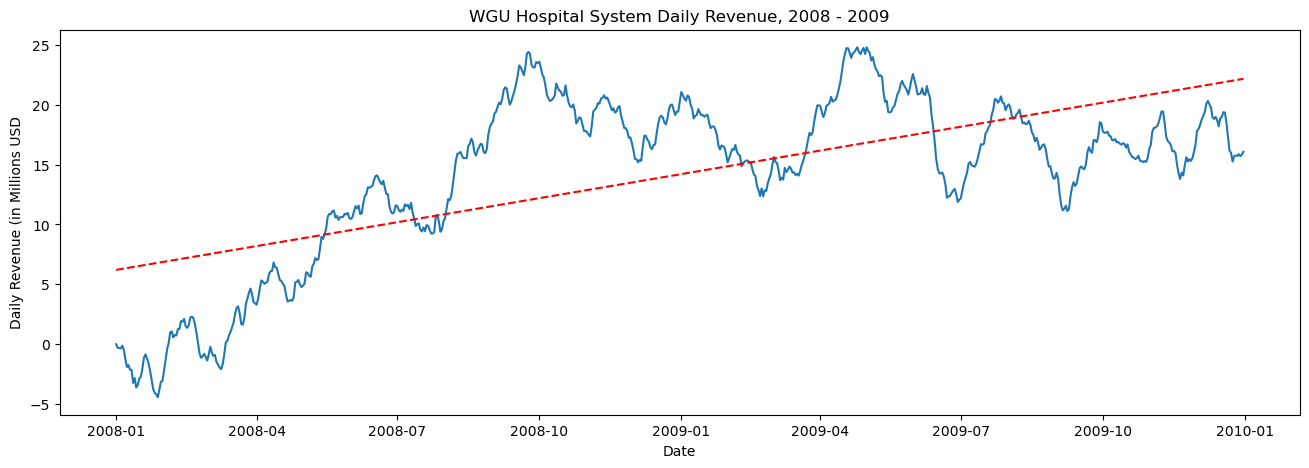

In [4]:
# Long X and small Y dictate a wide graph figure
plt.figure(figsize = [16,5])
# Prettify the graph
plt.title("WGU Hospital System Daily Revenue, 2008 - 2009")
plt.xlabel("Date")
plt.ylabel("Daily Revenue (in Millions USD")
# Plot time series data
plt.plot(df)
# Generate trend line
x = mdates.date2num(df.index)
y = df.revenue
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
# Plot trendline
plt.plot(x, p(x), "r--")
plt.show()

With the data cleaned up a bit and appropriately labelled, we can see the above line graph of the WGU Hospital System's daily revenue in millions of dollars USD over the course of two years (2008 - 2009). This line graph clearly demonstrates an upward trend in daily revenue over that time period, and this conclusion is further evidenced by the included trendline (in red). The ups and downs throughout the graph could reflect some seasonality elements, though this would require further analysis and any long term seasonality (on the order of months of the year) would likely require a larger dataset. 

<a id="#PartC2"></a>
## C2: Description of Time Step Formatting

The time series consists of a DateTime index and a corresponding observation of that day's revenue in millions of dollars USD for the entire WGU Hospital System. The datetime index increments by a single day for each observation (Jan 01 2008, Jan 02 2008, ..., Dec 31 2009). There appear to be no gaps in measurement. The sequence is 731 datapoints long, reflecting a leap year (an extra day in the month of February) in 2008. With the data formatted as a DateTime object, this facilitates a number of potential aggregations (revenue by week, by month, by year) or other manipulations of the data. 

<a id="#PartC3"></a>
## C3: Stationarity of Series

The data is obviously not stationary. A stationary time series does not have a trend. The above data clearly demonstrates an upward trend, as the hospital system's daily revenue started out within 5 million dollars of 0 for the first several months of the period in question, and the daily revenue by the end was regularly floating around 15-20 million dollars per day. This pattern is clear enough to demonstrate a definite upward trend in daily revenue, but I also added a trend line to the plot just to verify this. The dashed red line above is clearly pointing upward, indicating an increasing trend, and the matter isn't even particularly close. This data is definitely not stationary. 

<a id="#PartC4"></a>
## C4: Data Preparation & Explanation

There are several steps that will need to be performed in order to prepare this data for a time series analysis. 
- The "Day" column needs to be converted to a proper DateTime (see C1 above)
- The fixed "Day" column needs to be turned into the index of the time series (see C1 above)
- The "Revenue" data needs to be transformed into a stationary time series, without trend or seasonality
- The data needs to be separated into training and test sets

In [5]:
# Perform Augmented Dicky-Fuller on data
adfuller_results = adfuller(df.revenue)
# Print resulting test-statistic and p-value
print(f"The test statistic of an augmented Dicky-Fuller test on this data is {round(adfuller_results[0], 4)}, which has a p-value of {round(adfuller_results[1], 4)}")

The test statistic of an augmented Dicky-Fuller test on this data is -2.2183, which has a p-value of 0.1997


When performing an augmented Dicky-Fuller test, the null hypothesis is that the data is non-stationary. Thus, the test needs a resulting p-value under 0.05 to reject the null hypothesis (the data is not stationary), allowing us to conlude that the data *is* stationary. A more negative test statistic indicates a greater likelihood to be stationary. In this case, we have a somewhat small test statistic, and a p-value of ~0.20, indicating that this data is indeed non-stationary, consistent with our prior conclusions. In order to make it stationary, I will transform it, by taking the difference of each successive datapoint, using the `diff()` method. This will create an empty entry on the first date, because there is no preceding date to take the difference of. This will be omitted from the transformed data by using `dropna()`, reducing the data series from 731 points to 730 (Jan 2 2008 - Dec 31 2009).

The test statistic of an augmented Dicky-Fuller test on this data is -17.3748, which has a p-value of 0.0


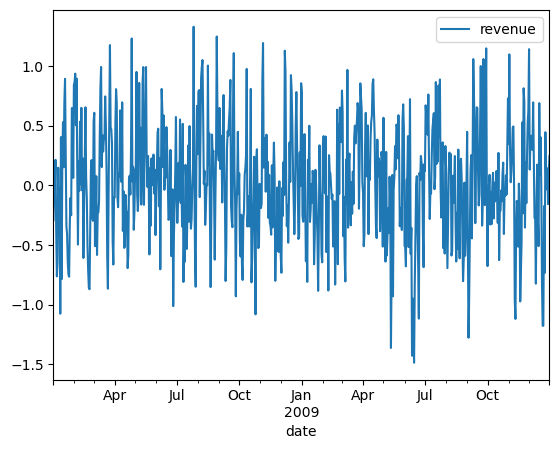

In [6]:
df_trans = df.diff().dropna()
# Perform Augmented Dicky-Fuller on data
adfuller_results = adfuller(df_trans.revenue)
# Print resulting test-statistic and p-value
print(f"The test statistic of an augmented Dicky-Fuller test on this data is {round(adfuller_results[0], 4)}, which has a p-value of {round(adfuller_results[1], 8)}")
# Plot to verify stationarity
df_trans.plot();

The above plot and augmented Dicky-Fuller results indicate that the data is now stationary. We do not see any apparent trend or even seasonality in the data, so we can carry on to splitting the data into training and test sets. 

Ordinarily, I would use SciKit-Learn's `TimeSeriesSplit` functionality on the time series to perform cross validation training & testing across the dataset. However, I am specifically required by the rubric to provide the dataset split into both Train and Test sets, meaning that I need clearly defined training/testing sets that can be exported to CSV, rather than using a variety of of splits like `TimeSeriesSplit` would do. As a result, I will instead use SciKit-Learn's `train_test_split`, but with `shuffle=False` in order to make sure that the time series data is not rearranged and maintains its order. 

In [7]:
# Split time series into a training set and a test set
train, test = train_test_split(df_trans, test_size=0.2, shuffle=False, random_state=369)
train

,revenue
date,
2008-01-02,-0.292356
2008-01-03,-0.035416
2008-01-04,-0.012215
2008-01-05,0.215100
2008-01-06,-0.366702
...,...
2009-08-03,-0.694370
2009-08-04,-0.282765
2009-08-05,0.104732


In [8]:
test

,revenue
date,
2009-08-08,0.263991
2009-08-09,-0.588690
2009-08-10,-0.550427
2009-08-11,0.081477
2009-08-12,-0.146587
...,...
2009-12-27,-0.032693
2009-12-28,0.143766
2009-12-29,-0.156834


<a id="#PartC5"></a>
## C5: Copy of Prepared Data Set

With the data split into both a training (80%) and a test set (20%), I can provide the prepared datasets as required by the rubric. The training set is saved as 'task1_train_clean.csv', while the test set is saved as 'task1_test_clean.csv'.

In [9]:
# Save dataframe to CSV
train.to_csv('task1_train_clean.csv')
# Save dataframe to CSV
test.to_csv('task1_test_clean.csv')

<a id="#PartD1"></a>
## D1: Annotated Findings & Visualizations

This element of the rubric is confusing, because it seems to be asking questions of the entire dataset, despite our having already split the dataset into two pieces (training and testing). Furthermore, some of these issues were already addressed above in assessing the stationarity of the dataset and informing our decision to transform it. Being bound to the rubric, I'm going to read this as looking for this information about the entire transformed dataset, and I will provide it as such. 

#### Seasonality

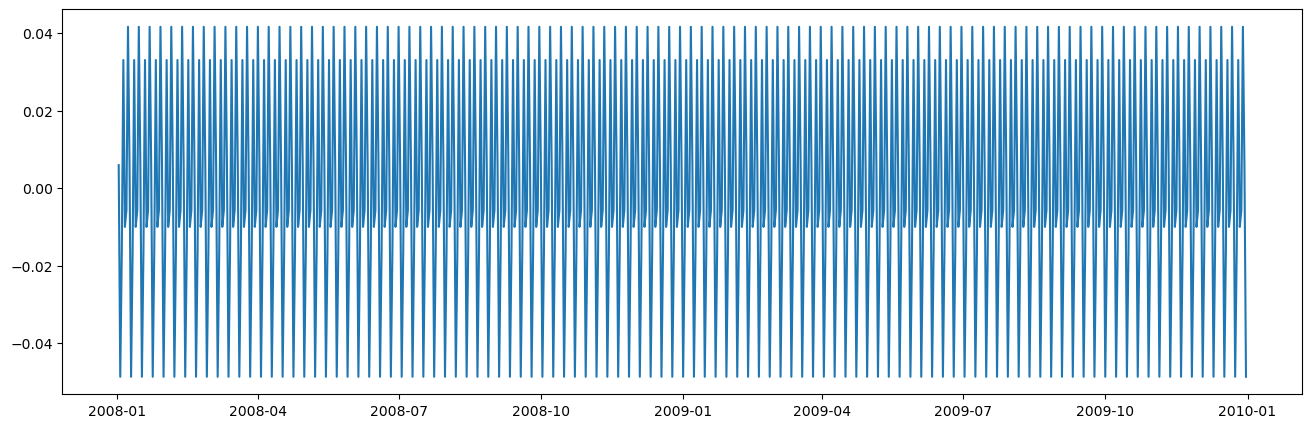

In [10]:
# Decompose the transformed data
decomposed_data = seasonal_decompose(df_trans)
# Long X and small Y dictate a wide graph figure
plt.figure(figsize = [16,5])
# Plot seasonal component of the data
plt.plot(decomposed_data.seasonal);

By decomposing the data and looking at the seasonal component, we find a consistent, repetitive pattern. This indicates seasonality, though the magnitude of this seasonal component (as indicated by the y-axis) is very small, around 0.04 in either direction of zero at its most extreme, compared to an overall magnitude in the dataset of 1.0 - 1.5. Given the scope the observed seasonality (happening several times within a period of months), this is likely a phenomenon related to the days of the week. We can verify this, plotting a month in the middle of the dataset to take a closer look at the data. 

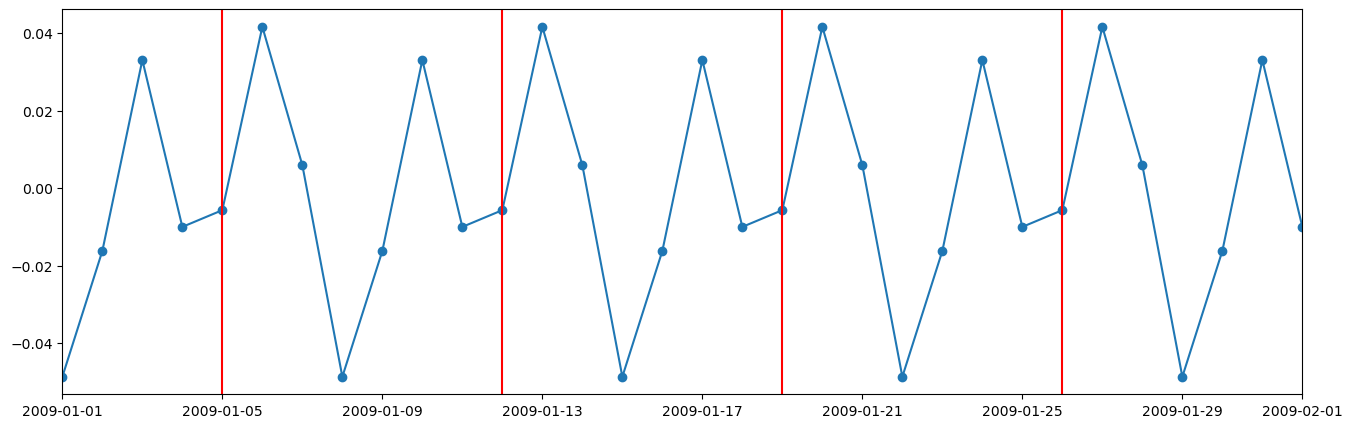

In [11]:
# Long X and small Y dictate a wide graph figure
plt.figure(figsize = [16,5])
# Plot seasonal component of the data
plt.plot(decomposed_data.seasonal, marker='o')
plt.xlim(pd.to_datetime('2009-01-01'), pd.to_datetime('2009-02-01'))
# Draw red lines on Mondays
plt.axvline(x=pd.to_datetime('2009-01-05'), color='red')
plt.axvline(x=pd.to_datetime('2009-01-12'), color='red')
plt.axvline(x=pd.to_datetime('2009-01-19'), color='red')
plt.axvline(x=pd.to_datetime('2009-01-26'), color='red');

In the above graph, we can more clearly see the seasonality for the period from January 1 2009 to February 1 2009. The red lines occur on Mondays (I checked a 2009 calendar), so we can count datapoints to the left or right to see the values for different days of the week. It appears that there are two peaks in each week, one on Saturday (two points to the left of the Monday-lines) and another on Tuesday (one point to the right of the Monday-lines). There are two noticeable troughs in each week, one occurring on Sunday (one point to the left of the Monday-lines) and another on Thursday (three points right of the Monday-lines). 

As mentioned, the impact of this seasonality seems very small, compared to the transformed data. The results of the previously performed augmented Dicky-Fuller test indicate that our data is indeed stationary. For what its worth, in developing this report, I did attempt to address the seasonality by removing the value for each datapoint's seasonality from the overall value for that date. This did remove the seasonality component (seasonality was still evident, but the magnitude was reduced to sextillionths), but when I performed a new augmented Dicky-Fuller test, the results were actually slightly worse in terms of the dataset's stationarity. As such, I elected not to try to pursue eliminating this very minor seasonality impact.  

Also worth noting is that the apparent seasonality element here, though small, could lend itself to a SARIMAX model, rather than an ARIMA model. I will not be doing this, because the rubric specifies an ARIMA model be used, and I have previously had projects returned to me for "doing too much" and violating the specific requirements of the rubric in similar ways. Thus, we're sticking with an ARIMA model, even if a SARIMAX model might be better. 

#### Trends

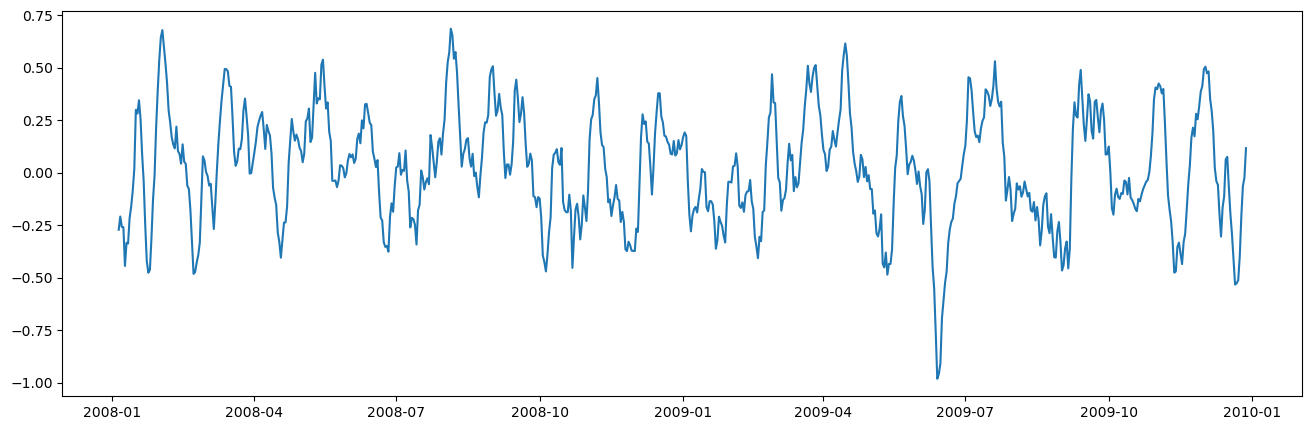

In [12]:
# Long X and small Y dictate a wide graph figure
plt.figure(figsize = [16,5])
# Plot trend component of the data
plt.plot(decomposed_data.trend);

There is no apparent overall trend in the dataset. We do see what might be an outlier in the summer of 2009.

#### Auto Correlation Functions 

C:\Users\hasek\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


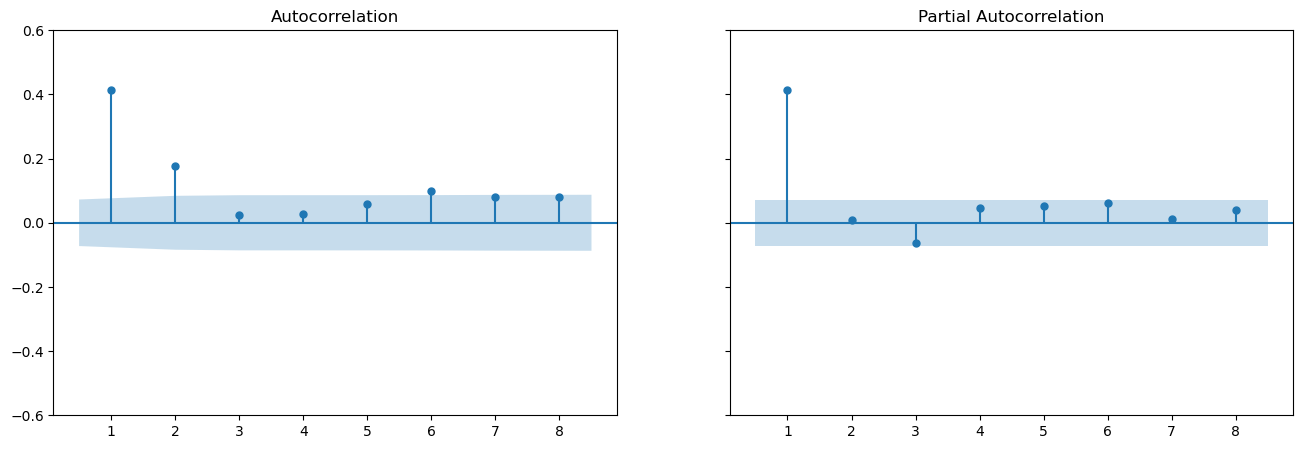

In [13]:
# Plot Autocorrelation and Partial Autocorrelation in one figure, sharing a y axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,5], sharey=True)
# Plot ACF to 8 lags (only 7 days in a week), ignore zero (zero always = 1)
plot_acf(df_trans, lags=8, zero=False, ax=ax1)
# Plot PACF to 8 lags (only 7 days in a week), ignore zero (zero always = 1)
plot_pacf(df_trans, lags=8, zero=False,ax=ax2)
# Zoom in on y axis to see points a little more clearly
plt.ylim(-0.6, 0.6);

We can use the ACF and PACF to determine whether this data is an AR (autoregression) or MA (moving average) model. The shaded area represents statistically insignificant results, so those datapoints can be ignored. It appears that the ACF tails off at 2 (this is a bit of a subjective distinction), while the PACF clearly cuts off at 1. Referring to the DataCamp course materials [(DataCamp: ARIMA Models in Python, by James Fulton)](https://campus.datacamp.com/courses/arima-models-in-python/the-best-of-the-best-models?learningMode=course&ex=1), a ACF that tails off and a PACF that cuts off after lag `p` indicates an AR model of order `p`. The behavior of this data indicates that this data is best suited to an AR(1) model. 

#### Spectral Density

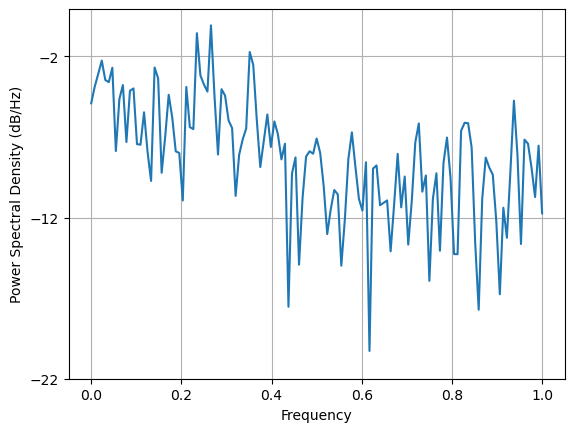

In [14]:
plt.psd(x=df_trans.revenue);

Above is a plot of the power spectral density of the transformed time series. 

#### Decomposed Time Series

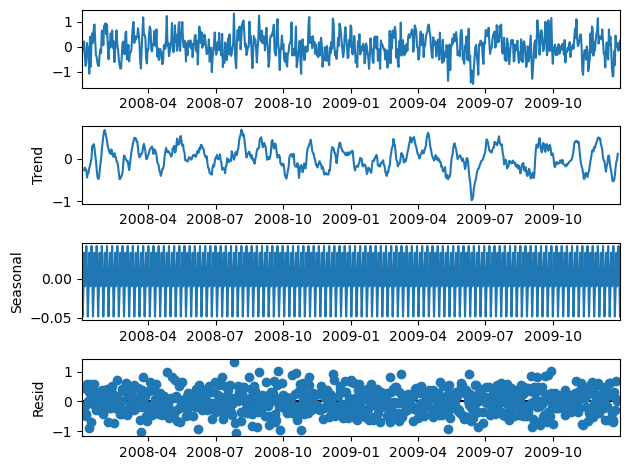

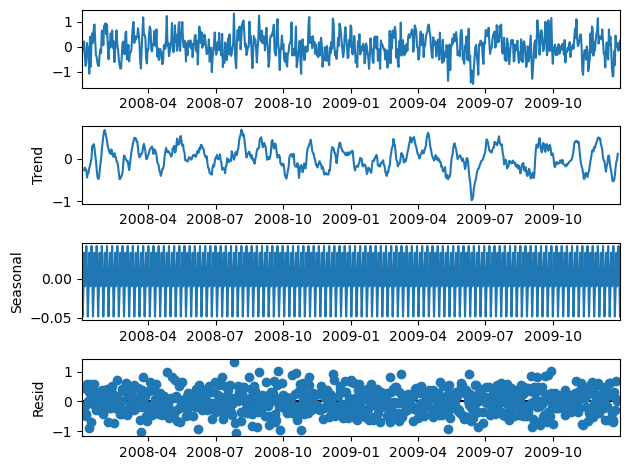

In [15]:
decomposed_data.plot()

Once again, the rubric isn't entirely clear on what this wants. I think this is referring to the fully decomposed contents of the time series, though this is strange to request when also requesting the discrete elements that are already presented here, of which another one is requested in the next section. 

#### Confirmed Lack of Trends in Residuals of Decomposition 

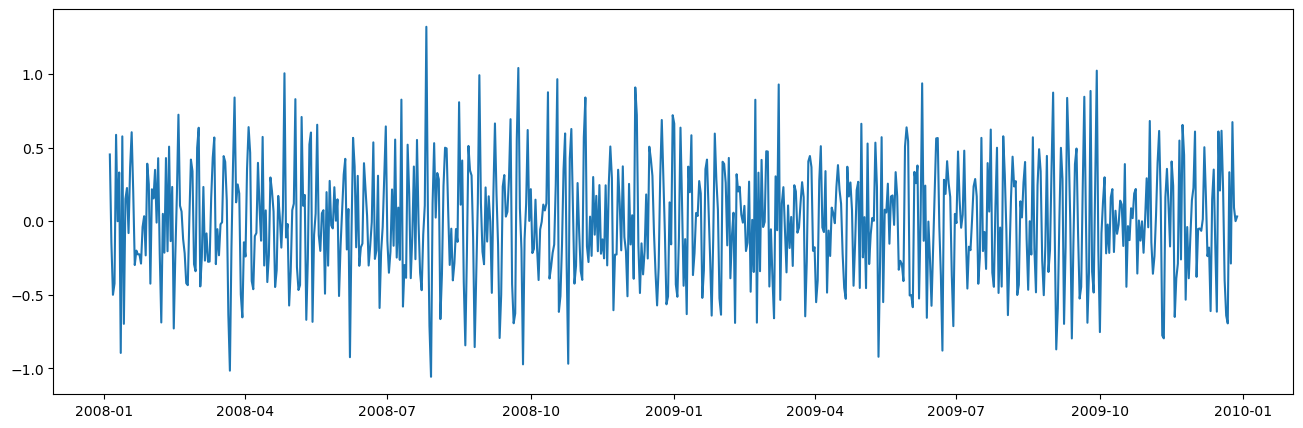

In [16]:
# Long X and small Y dictate a wide graph figure
plt.figure(figsize = [16,5])
# Plot residual component of the data
plt.plot(decomposed_data.resid);

The residuals of the decomposition do not appear to have any apparent trend. 

<a id="#PartD2"></a>
## D2: ARIMA Model of Time Series Data

As mentioned above in the ACF and PACF plots, the trends within each of those plots indicate that this data is best suited to an AR(1) model. 

In [17]:
model = ARIMA(train, order=(1, 0, 0), freq='D')
results = model.fit()
print(results.summary())

C:\Users\hasek\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -350.349
Date:                Thu, 02 Feb 2023   AIC                            706.698
Time:                        22:06:04   BIC                            719.808
Sample:                    01-02-2008   HQIC                           711.808
                         - 08-07-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0328      0.031      1.063      0.288      -0.028       0.093
ar.L1          0.4079      0.038     10.748      0.000       0.333       0.482
sigma2         0.1943      0.012     15.948      0.0

Based on the above coefficients, this provides us the resulting ARIMA equation:

$$ X_t = 0.4079(X_{(t-1)}) + 0.0194 + a_t $$

<a id="#PartD3"></a>
## D3: Forecast

The testing dataset is 146 rows long, so I'm going to attempt to forecast for those 146 values. This gives us a point of comparison, where we can check the predicted value against the actual value found in the test set. 

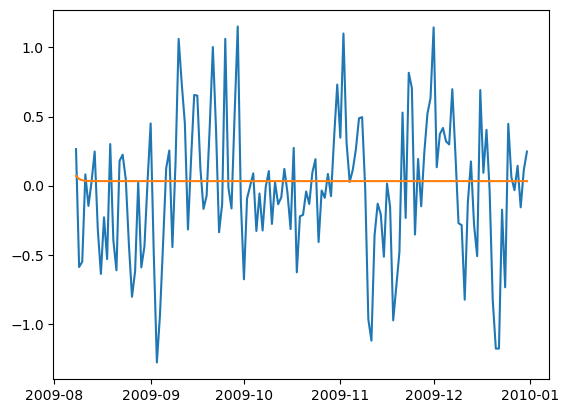

In [18]:
forecasted = results.get_prediction(start = 584, end = 729, dynamic = True)
plt.plot(test)
plt.plot(forecasted.predicted_mean);

In [19]:
print(forecasted.predicted_mean)

2009-08-08    0.071071
2009-08-09    0.048405
2009-08-10    0.039159
2009-08-11    0.035388
2009-08-12    0.033850
                ...   
2009-12-27    0.032791
2009-12-28    0.032791
2009-12-29    0.032791
2009-12-30    0.032791
2009-12-31    0.032791
Freq: D, Name: predicted_mean, Length: 146, dtype: float64


As we can see, the forecast is not particularly effective. I had initially thought the forecast generated an array of zeros, but it actually starts with a slight bump before tapering downward and anchoring to the value 0.032791. This value is not actually a prediction of the daily revenue for the WGU Hospital System, but rather, a prediction of the *daily difference* in daily revenue. This means that the ARIMA is not actually predicting 0.032791 in millions of daily revenue, but rather a difference from the day prior of 0.032791, meaning that it's predicting revenue to steadily increase by that amount, additively. 

Knowing this, we can actually invert our earlier transformation and plot the predicted data vs the observed data in the test set. We'll also calculate the confidence intervals for the forecast and plot those as well. 

In [20]:
# Place the forecasted differences into a temporary dataframe
forecast_temp = pd.DataFrame(forecasted.predicted_mean)
# Make consistent names for dataframe for concatenation
forecast_temp.rename(columns={'predicted_mean' : 'revenue'}, inplace=True)
# Concat a copy of Train (thru Aug 07 2009) and a copy of forecasted values (forward from Aug 08 2009)
df_w_forecast = pd.concat([train.copy(), forecast_temp.copy()])
# We've generated one DF with the differences in daily revenue for the entire 2-year period, invert the differences using cumsum
df_w_forecast = df_w_forecast.cumsum()
# Check output to verify expected values 
df_w_forecast

,revenue
2008-01-02,-0.292356
2008-01-03,-0.327772
2008-01-04,-0.339987
2008-01-05,-0.124888
2008-01-06,-0.491590
...,...
2009-12-27,24.033683
2009-12-28,24.066474
2009-12-29,24.099265
2009-12-30,24.132056


In [21]:
# Calculate confidence intervals from forecasted data
confidence_intervals = forecasted.conf_int()
# Like the forecast, these confidence limits are also differences in daily revenue, these need transformed back to daily revenue
confidence_intervals

,lower revenue,upper revenue
2009-08-08,-0.792856,0.934998
2009-08-09,-0.884621,0.981430
2009-08-10,-0.904871,0.983190
2009-08-11,-0.910461,0.981237
2009-08-12,-0.912301,0.980001
...,...,...
2009-12-27,-0.913421,0.979002
2009-12-28,-0.913421,0.979002
2009-12-29,-0.913421,0.979002
2009-12-30,-0.913421,0.979002


In [22]:
# Establish a dataframe to match the confidence intervals dataframe, including the UNTRANSFORMED data from 2009-08-07
previous_row = pd.DataFrame({'lower revenue': [19.312734], 'upper revenue' : [19.312734], 'date' : ['2009-08-07']})
# Convert given date string to datetime and then set as index
previous_row['date'] = pd.to_datetime(previous_row['date'])
previous_row.set_index('date', inplace=True)
previous_row

,lower revenue,upper revenue
date,,
2009-08-07,19.312734,19.312734


In [23]:
# Concatenate the prior row and the confidence intervals data
confidence_intervals = pd.concat([previous_row, confidence_intervals])
# Un-transform the confidence intervals using cumsum()
confidence_intervals = confidence_intervals.cumsum()
# Make sure first row (data preceding the forecast) is omitted
confidence_intervals = confidence_intervals.loc['2009-08-08' : '2009-12-31']
# Verify un-transformed confidence intervals
confidence_intervals

,lower revenue,upper revenue
2009-08-08,18.519878,20.247732
2009-08-09,17.635257,21.229163
2009-08-10,16.730386,22.212353
2009-08-11,15.819925,23.193590
2009-08-12,14.907624,24.173592
...,...,...
2009-12-27,-110.230261,158.297627
2009-12-28,-111.143681,159.276629
2009-12-29,-112.057102,160.255632
2009-12-30,-112.970522,161.234634


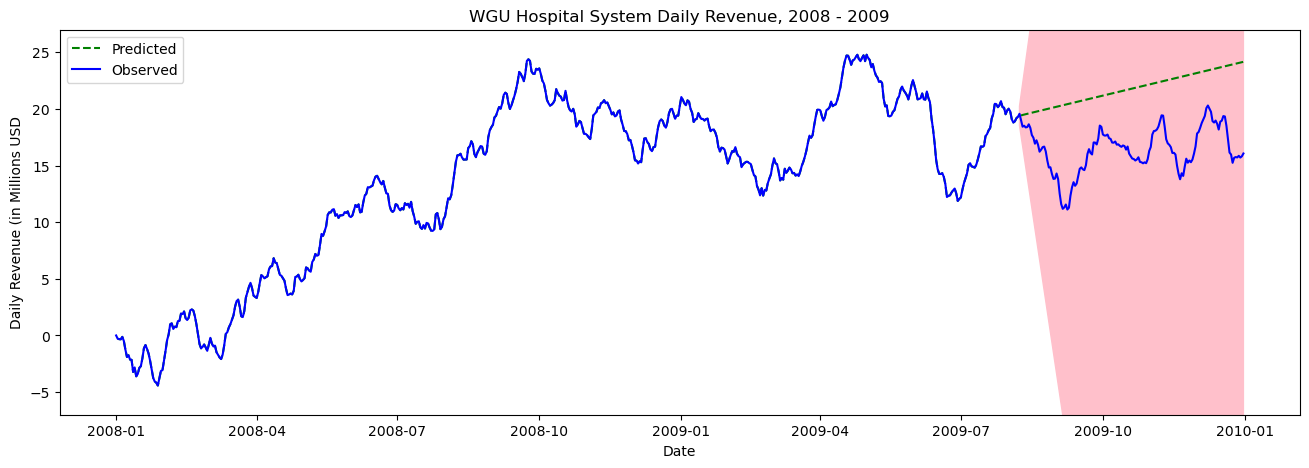

In [24]:
# Long X and small Y dictate a wide graph figure
plt.figure(figsize = [16,5])
# Prettify the graph
plt.title("WGU Hospital System Daily Revenue, 2008 - 2009")
plt.xlabel("Date")
plt.ylabel("Daily Revenue (in Millions USD")
# Plot the forecasted data
plt.plot(df_w_forecast, color = 'green', linestyle = 'dashed')
# Plot the original data (includes both the train set and the test set, untransformed - their actual observed values)
plt.plot(df, color = 'blue')
# Plot the confidence intervals
plt.fill_between(confidence_intervals.index, confidence_intervals['lower revenue'], confidence_intervals['upper revenue'], color = 'pink')
# Keep the y-axis zoomed in, without expanding to fit the full confidence interval values
plt.ylim(-7, 27)
# Provide legend to distinguish predicted values from observed values
plt.legend(['Predicted', 'Observed'])
plt.show();

The above plot shows the WGU Hospital System's daily revenue, including both the forecast for the back 20% of the period (Aug 08 2009 - Dec 31 2009) based on the prior 80% of the period, and the actual values for that period. The model has a wide confidence interval, and when extrapolated over such a large forecasting period (146 days in advance), this compounds upon itself, expanding the confidence interval to an unreasonable range. 

Having performed the forecast, we can also generate elements to evaluate the model. This includes the root mean square error as well as the diagnostic plots. 

In [25]:
# Calculate root mean squared error of forecasted data against the observed data (both untransformed)
rmse = mean_squared_error(df.loc['2009-08-08' : '2009-12-31'], df_w_forecast.revenue.loc['2009-08-08' : '2009-12-31'], squared=False)
print(f"The root mean squared error of this forecasting model is {round(rmse, 5)}")

The root mean squared error of this forecasting model is 5.7584


<Figure size 1600x1600 with 0 Axes>

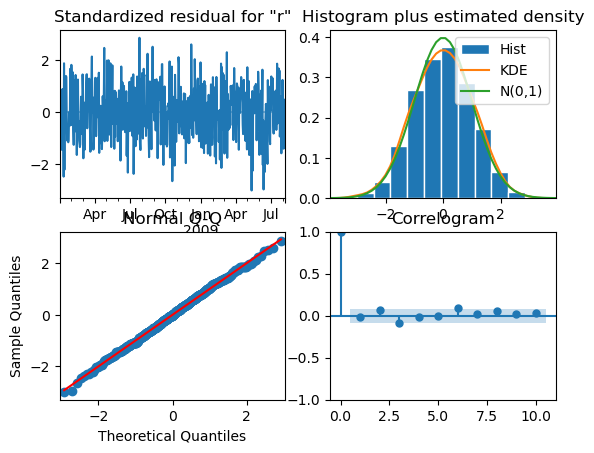

In [26]:
plt.figure(figsize = [16,16])
results.plot_diagnostics();

<a id="#PartD4"></a>
## D4: Analysis Output & Calculations

All of the calculations that I've performed, and their resulting outputs, can be seen above. 

<a id="#PartD5"></a>
## D5: ARIMA Model Code

All of the code used to implement the model has been provided. 

<a id="#PartE1"></a>
## E1: Results of Analysis

As explained above in this report, the autocorrelation and partial autocorrelation functions are used to determine if this data is best suited to an AR (autoregression) or MA (moving average) model. With the observed behavior in section D1 of the ACF tailing off at 2 and the PACF cutting off at 1, this indicates that the model is best suited for a model of AR(1). There are other ways to determine the appropriate order of an ARIMA model, but I felt that this one worked adequately within the restrictions of the assignment rubric. As a result, the ARIMA model has an overall order of (1, 0, 0). Fitting the ARIMA model to the training data indicates that the equation for this dataset is:

$$ X_t = 0.4079(X_{(t-1)}) + 0.0194 + a_t $$

The prediction interval of the forecast is 146 steps after the end of the training data, or 20% of the full dataset. When splitting into training and test sets, 20-30% of the overall data being placed into the test set is a reasonable decision. Given that this is a very large amount of time to forecast, I went with the minimal value of 20% of the data being in the test set. This amounts to predicting approximately 5 months worth of revenue, based on only 19 months of data. 

As mentioned in section B (ARIMA assumptions), I do have concern that a significant portion of that 19 months of training data may not necessarily be representative of later data because of everything that goes into beginning business observations. This concern appears to be somewhat justified, as I can see three general "phases" or "eras" in the data. Within the first 3-4 months, the daily revenue is wavering back and forth around 0, indicative of the early stages of getting a new (and very large) business up and running. After that, there appears to be another 4-5 months of steadily increasing revenue, until reaching the range where revenue would generally stay for the remainder of the observation period (15 - 25 million per day). If this plateau is indicative of the true performance of the hospital system, then the first 7 - 9 months of operation represent a "spin-up" period and are not predictive of future performance. This means that over 25% of the dataset would potentially be hindering the predictive value of the model. 

The forecast interval itself is justifiable, though it is ambitious based on these issues with the dataset. Revenue forecasts in both the short and medium term are regular business needs. I believe the biggest issue here lies with the fact that of 19 months of data used to generate predictions, only 10-12 months of that has a likely predictive value. A larger dataset which omits the first 7 - 9 months of non-predictive data would likely provide a better forecast than this model did. 

The model's forecast can be evaluated relative to other models by using the root mean squared error. The root mean squared error of this model is 5.7584. A lower rMSE is better and indicates a more accurate model. This would be a point of comparison against other models. 

Independently, the model's performance can be evaluated by the output of `diagnostic_plots()`. 

<Figure size 1600x1600 with 0 Axes>

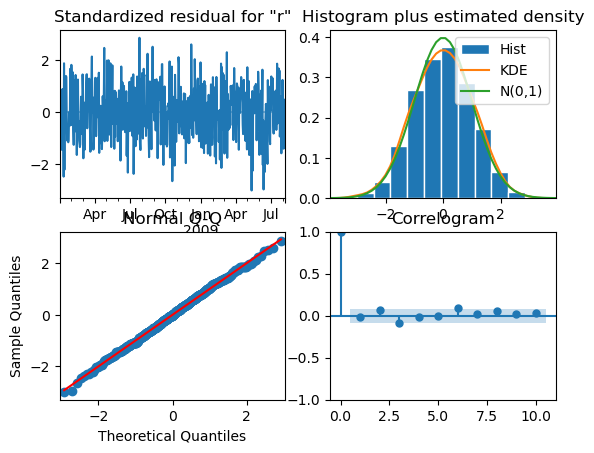

In [27]:
plt.figure(figsize = [16,16])
results.plot_diagnostics();

The `plot_diagnostics()` function generates a series of plots about the model's performance. 
- The top left is the standardized residual plot, which should contain no obvious patterns. This plot does not show any apparent patterns. 
- The top right is the histogram with KDE estimate. The KDE curve should be very close to the normal distribution, which ours is.
- The bottom left is the Normal Q-Q plot. Most (preferably all) of the datapoints should occur on the red line, which is the case here. 
- The bottom right is the correlogram. All correlations for lag greater than zero should be insignificant, meaning they should be in the shaded area. This model appears to have elements at lag(3) and lag(6) which look to be right on the border of being significant. 

The results of the correlogram indicate that the model may have slightly too much correlation for particular lag values. This is likely related to the very slight seasonality by day of the week effect that was examined earlier. Nonetheless, this model doesn't appear to be particularly problematic from a statistical perspective. It do believe that it does lack practical significance, however, based upon the imprecise nature of its forecasting, only accounting for a slight linear upward increase in daily revenues. This is a conclusion of limited value, especially given the confidence range associated with this forecast. 

<a id="#PartE2"></a>
## E2: Visualization of Forecast

Below is the final visualization, plotting both the observed data provided by WGU and the forecast generated by this model, including the confidence interval. 

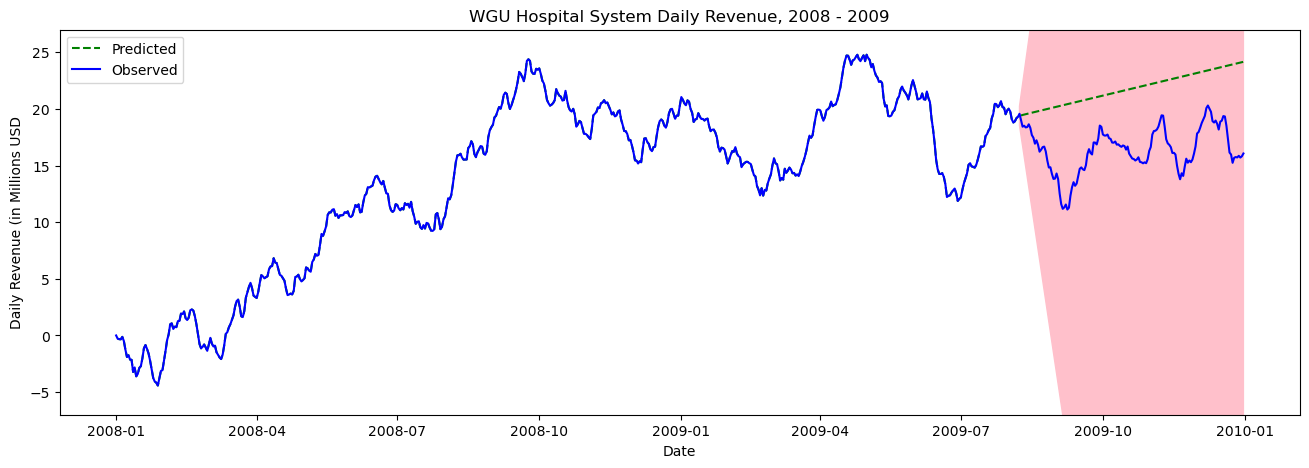

In [28]:
# Long X and small Y dictate a wide graph figure
plt.figure(figsize = [16,5])
# Prettify the graph
plt.title("WGU Hospital System Daily Revenue, 2008 - 2009")
plt.xlabel("Date")
plt.ylabel("Daily Revenue (in Millions USD")
# Plot the forecasted data
plt.plot(df_w_forecast, color = 'green', linestyle = 'dashed')
# Plot the original data (includes both the train set and the test set, untransformed - their actual observed values)
plt.plot(df, color = 'blue')
# Plot the confidence intervals
plt.fill_between(confidence_intervals.index, confidence_intervals['lower revenue'], confidence_intervals['upper revenue'], color = 'pink')
# Keep the y-axis zoomed in, without expanding to fit the full confidence interval values
plt.ylim(-7, 27)
# Provide legend to distinguish predicted values from observed values
plt.legend(['Predicted', 'Observed'])
plt.show();

As discussed already, the model forecast a very slight but steady increase in daily revenues for the WGU Hospital System. The attempt to forecast hospital system revenues is technically successful, but the forecast projects increasing revenues where in reality those revenues dropped precipitously. As a result, the forecast is not of particular practical value, and I have to declare that I have not been successful in effectively forecasting the WGU Hospital System's daily revenues. 

<a id="#PartE3"></a>
## E3: Recommended Action

The lack of practical significance of this model makes it difficult to recommend anything besides further study. Subsequent forecasting attempts would benefit from a larger dataset, as well as omitting the first 7-9 months of the hospital system's data, as discussed above. Additional context would also be useful, such as notation of when additional hospitals begin operation, so that they can either be included in the dataset (and their impact on the data understood) or omitted to maintain a consistent comparison over time. At present, the provided dataset is of limited usefulness due to the lack of this sort of important context and the non-predictive nature of the first third of the data. 

This does lead me to two courses of action that should be kept in mind going forward. First of all, revenue data should be collected on a per-hospital basis, rather than accumulated into a single organization-wide bucket. This provides additional granularity to compare hospitals, but it also allows for the handling of contextual factors based on each hospital. Forecasting models can be developed for each hospital, and the outputs of these models can then be combined to generate an overall organizational forecast that it likely to be much more accurate than this process was. Second, as an example of the individualized contextual factors that can be accounted for when the data is divided in this way, I would recommend that the revenue data for the first 6 months of any hospital which begins operations be omitted from any similar analysis. This avoids the issues that I explained above, while allowing each hospital to contribute to the organization's whole after a reasonable "spin-up" time.  

<a id="#PartF"></a>
## F: Reporting

This section of the rubric requires that I perform the sections in Part E in a development environment, such as a Jupyter Notebook. This assignment is submitted as both a Jupyter Notebook .ipynb file and a PDF of the same. 

<a id="#PartG"></a>
## G: Code References

[StackOverflow: Converting Day Count to Date Time](https://stackoverflow.com/questions/61389654/converting-day-count-to-date-time) was used for fixing the 'Day' column of the provided dataset to convert to a DateTime, starting at January 1 2008.

[StackOverflow: Add Trendline for TimeSeries Graph in Python](https://stackoverflow.com/questions/61011711/add-trendline-for-timeseries-graph-in-python) was used to plot the trend line on the initial line graph of the dataset, to clearly demonstrate that the data was not stationary. 

[Geeks for Geeks: Plot the Power Spectral Density](https://www.geeksforgeeks.org/plot-the-power-spectral-density-using-matplotlib-python/) was used for plotting the spectral density. 

[StackExchange: Converting ARIMA Output to Equation Form](https://stats.stackexchange.com/questions/340838/good-resource-for-converting-arima-output-in-r-to-equation-form) was used for convering the ARIMA summary() information into an ARIMA equation.

[DataCamp: ARIMA Models in Python, by James Fulton](https://campus.datacamp.com/courses/arima-models-in-python/fitting-the-future?ex=8&learningMode=course) was used for assistance with generating and plotting the dynamic forecast and especially with the associated confidence intervals. 

<a id="#PartH"></a>
## H: Source References

[DataCamp: ARIMA Models in Python, by James Fulton](https://campus.datacamp.com/courses/arima-models-in-python/the-best-of-the-best-models?learningMode=course&ex=1) was used for determining the order of the ARIMA model best suited to the data. 